# Tutorial 6: Discern biologically distinct anomalous tissue subdomains across multiple ST datasets

We use STANDS to discern biologically distinct anomalous tissue subdomains in multiple ST datasets. Specifically, this experiment involves a normal breast tissue dataset (10x-hNB-v07) and two breast cancer datasets (10x-hBC-G2, 10x-hBC-H1). The cancer in situ and invasive cancer shared in 10x-hBC-G2 and 10x-hBC-H1 are regarded as the anomaly subdomains.

## Loading package

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import stands
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

## Reading ST data

We read the processed ST datasets. In the example, the demo datasets includes: 1) gene expression matrix in `adata.X`; 2) spatial coordinates in `adata.obsm['spatial']`; 3) histology image in `adata.uns['spatial']`. To make the model can read the data sucessfully, please ensure the same anndata structure as example.

In [3]:
ref = sc.read_h5ad('./HumanBreast/process/V07.h5ad')
tgt1 = sc.read_h5ad('./HumanBreast/process/G2.h5ad')
tgt2 = sc.read_h5ad('./HumanBreast/process/H1.h5ad')

In [4]:
ref

AnnData object with n_obs × n_vars = 2086 × 3000
    obs: 'cell_type', 'batch', 'disease'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
tgt1

AnnData object with n_obs × n_vars = 467 × 3000
    obs: 'cell_type', 'batch', 'disease'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
tgt2

AnnData object with n_obs × n_vars = 613 × 3000
    obs: 'cell_type', 'batch', 'disease'
    uns: 'spatial'
    obsm: 'spatial'

## Converting data

For ST input, STANDS first needs to convert the anndata data into a graph, where nodes represent each spot and edges represent the adjacency relationship between two spots. In the example, the node features of the converted graph include the gene expression vector and image patch. Additionally, if the data has been preprocessed, you should set `preprocess=False`.

In [7]:
ref_g = stands.read(ref, patch_size=64, n_genes=3000, preprocess=False)
tgt_g = stands.read_multi([tgt1, tgt2], patch_size=64, n_genes=3000, preprocess=False)

## Detecting anomaly domains

The anomaly subtype module of STANDS is implemented based on the anomaly detection module. Firstly, the anomalous regions on the target dataset need to be detected using STANDS.

In [8]:
ADModel = stands.AnomalyDetect()
ADModel.fit(ref_g)

Begin to train the model on reference datasets...


Train Epochs: 100%|██████████| 10/10 [02:35<00:00, 15.58s/it, D_Loss=0.911, G_Loss=2.57]

Training has been finished.


In [9]:
scores, labels = ADModel.predict(tgt_g)

Detect anomalous spots on target dataset...
Anomalous spots have been detected.



In [10]:
# store the results
ref.obs['pred'] = 0
tgt1.obs['pred'] = labels[0]
tgt2.obs['pred'] = labels[1]

In [11]:
adata_g = stands.read_multi([ref, tgt1, tgt2], patch_size=64, n_genes=3000, preprocess=False)

## Aligning multiple datasets

The results of anomalous subtype detection can be affected due to the batch effect that exists between target datasets. Therefore, we align these datasets first.

In [12]:
BCModel = stands.BatchAlign(GPU='cuda:1')
adata = BCModel.fit(adata_g, ADModel.G)

Begin to find Kin Pairs between datasets...


Train Epochs: 100%|██████████| 1000/1000 [00:41<00:00, 24.19it/s, D_Loss=-.125, G_Loss=5.51]


Kin Pairs have been found.

Begin to correct spatial transcriptomics datasets...


Train Epochs: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it, D_Loss=0.156, G_Loss=1.72]

Datasets have been corrected.



In [13]:
anomaly = adata[adata.obs['pred'] == 1]

anomaly1 = anomaly[anomaly.obs['batch']==1]
anomaly1.uns = tgt1.uns
anomaly1.obsm = tgt1[tgt1.obs['pred'] == 1].obsm

anomaly2 = anomaly[anomaly.obs['batch']==2]
anomaly2.uns = tgt2.uns
anomaly2.obsm = tgt2[tgt2.obs['pred'] == 1].obsm

anomaly_list = [anomaly1, anomaly2]

## Training the model

In the anomaly subtype module of STANDS, since the generator of the anomaly detection module is used as extractor, it is also necessary to convert the anomaly data.

In [14]:
# convert detected anomaliesw
anomaly_g = stands.read_multi(anomaly_list, patch_size=64, n_genes=3000, preprocess=False)

In [15]:
ASModel = stands.Subtype(ADModel.G)
subtype = ASModel.fit(anomaly_g)

Train Epochs: 100%|██████████| 3000/3000 [02:26<00:00, 20.47it/s, Loss=0.0682]


In [16]:
# store the result
anomaly1.obs['subtype'] = subtype[0]
normal1 = tgt1[tgt1.obs['pred']==0]
normal1.obs['subtype'] = 0
tgt1.obs = pd.concat([anomaly1.obs, normal1.obs]).sort_index()
tgt1.obs['subtype'] = tgt1.obs['subtype'].astype('int')

anomaly2.obs['subtype'] = subtype[1]
normal2 = tgt2[tgt2.obs['pred']==0]
normal2.obs['subtype'] = 0
tgt2.obs = pd.concat([anomaly2.obs, normal2.obs]).sort_index()
tgt2.obs['subtype'] = tgt2.obs['subtype'].astype('int')

## Evaluation

STANDS integrates several evaluation metrics in `stands.evaluate` for anomaly detection tasks, which can be used very easily and directly.

In [17]:
# annotate ground truth labels
df = pd.DataFrame(tgt1.obs)
df['sub_label'] = np.nan

# disease == 1
disease_1_df = df[df['disease'] == 1].copy()
unique_cell_types = disease_1_df['cell_type'].unique()
subtype_mapping = {cell_type: i+1 for i, cell_type in enumerate(unique_cell_types)}
disease_1_df['sub_label'] = disease_1_df['cell_type'].map(subtype_mapping)

# disease == 0
disease_0_df = df[df['disease'] == 0].copy()
disease_0_df['sub_label'] = 0

df = pd.concat([disease_1_df, disease_0_df]).sort_index()
df['sub_label'] = df['sub_label'].astype('category')
df['subtype'] = df['subtype'].astype('category')

tgt1.obs = df

In [18]:
metrics = ['F1*NMI', 'SGD_degree', 'SGD_cc']
result = stands.evaluate(metrics, adata=tgt1, y_true=tgt1.obs['disease'], y_pred=tgt1.obs['pred'],
                         spaid='spatial', typeid='cell_type', clustid='subtype')

In [19]:
pd.DataFrame(zip(metrics, result))

,0,1
0,F1*NMI,0.350608
1,SGD_degree,0.938348
2,SGD_cc,0.527574


In [20]:
# annotate ground truth labels
df = pd.DataFrame(tgt2.obs)
df['sub_label'] = np.nan

# disease == 1
disease_1_df = df[df['disease'] == 1].copy()
unique_cell_types = disease_1_df['cell_type'].unique()
subtype_mapping = {cell_type: i+1 for i, cell_type in enumerate(unique_cell_types)}
disease_1_df['sub_label'] = disease_1_df['cell_type'].map(subtype_mapping)

# disease == 0
disease_0_df = df[df['disease'] == 0].copy()
disease_0_df['sub_label'] = 0

df = pd.concat([disease_1_df, disease_0_df]).sort_index()
df['sub_label'] = df['sub_label'].astype('category')
df['subtype'] = df['subtype'].astype('category')

tgt2.obs = df

In [21]:
metrics = ['F1*NMI', 'SGD_degree', 'SGD_cc']
result = stands.evaluate(metrics, adata=tgt2, y_true=tgt2.obs['disease'], y_pred=tgt2.obs['pred'],
                         spaid='spatial', typeid='cell_type', clustid='subtype')

In [22]:
pd.DataFrame(zip(metrics, result))

,0,1
0,F1*NMI,0.375369
1,SGD_degree,0.939437
2,SGD_cc,0.431424


## Visualization

We use the spatial map to visualise the results of anomaly detection.

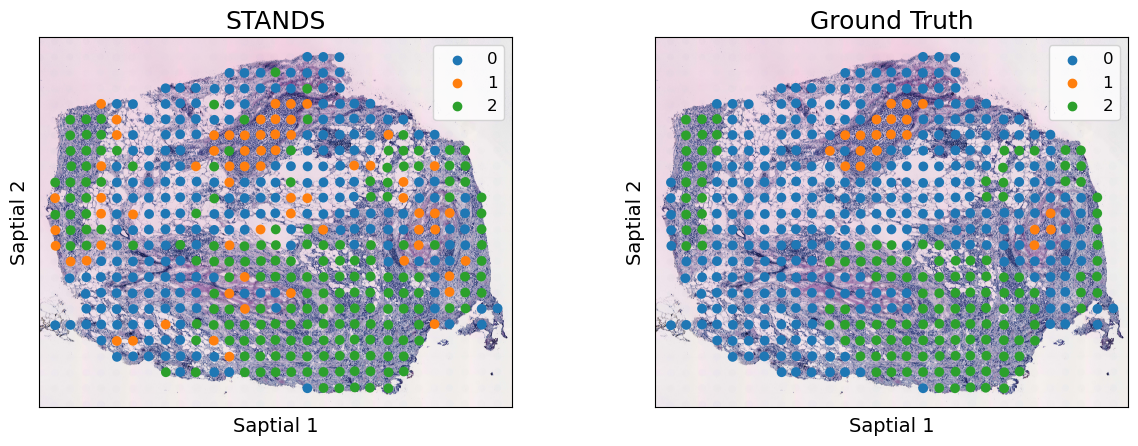

In [23]:
ax = sc.pl.spatial(tgt1, color=['subtype', 'sub_label'], s=90, show=False, crop_coord=(0, 8700, 800, 7600))

ax[0].legend(fontsize=12)
ax[0].set_title('STANDS', fontsize=18)
ax[0].set_xlabel('Saptial 1', fontsize=14)
ax[0].set_ylabel('Saptial 2', fontsize=14)

ax[1].legend(fontsize=12)
ax[1].set_title('Ground Truth', fontsize=18)
ax[1].set_xlabel('Saptial 1', fontsize=14)
ax[1].set_ylabel('Saptial 2', fontsize=14)

plt.show()

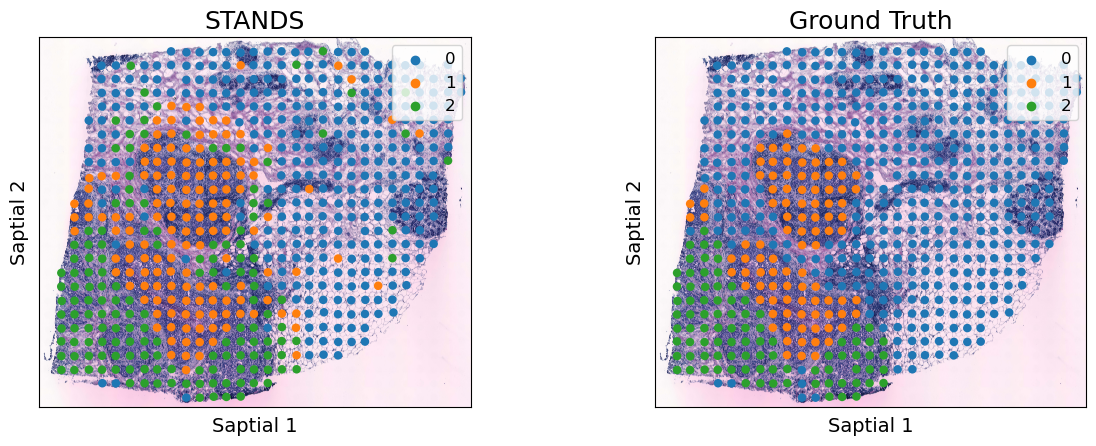

In [24]:
ax = sc.pl.spatial(tgt2, color=['subtype', 'sub_label'], s=90, show=False, crop_coord=(100, 9200, 2000, 9800))

ax[0].legend(fontsize=12)
ax[0].set_title('STANDS', fontsize=18)
ax[0].set_xlabel('Saptial 1', fontsize=14)
ax[0].set_ylabel('Saptial 2', fontsize=14)

ax[1].legend(fontsize=12)
ax[1].set_title('Ground Truth', fontsize=18)
ax[1].set_xlabel('Saptial 1', fontsize=14)
ax[1].set_ylabel('Saptial 2', fontsize=14)

plt.show()